# Faster R-CNN модификация 1
Источникик: https://www.sciencedirect.com/science/article/pii/S2590123024007424


Улучшения:
- использование деформированных сверток;
- использование CAM и SAM модулей;
- использование Soft-NMS.

# Импорт библиотек

In [1]:
!pip install -q kagglehub tqdm
!pip install torchmetrics
!pip install -U gdown -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 32.0 MB/s eta 0:00:00


In [2]:
import os
import json
import random
import datetime
import tempfile
import time
import types
import xml.etree.ElementTree as ET
from collections import Counter

import yaml
import numpy as np
import kagglehub
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import gdown

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, ConcatDataset

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import draw_bounding_boxes
from torchvision.ops import deform_conv2d

from torchvision.models.detection import (
    fasterrcnn_resnet50_fpn,
    fasterrcnn_resnet50_fpn_v2,
    FasterRCNN_ResNet50_FPN_Weights,
    FasterRCNN_ResNet50_FPN_V2_Weights,
    FasterRCNN,
)
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator

from torchmetrics.detection import MeanAveragePrecision

import math

# Загрузка датасета

Используемый датасет предоставлен в формате YOLOv11

In [3]:
path = kagglehub.dataset_download("romankornyushenkov/neu-det-v5")
print("Path to dataset files:", path)

yaml_path = os.path.join(path, "data.yaml")
with open(yaml_path, 'r') as f:
    data_config = yaml.safe_load(f)

print("Классы:", data_config['names'])
print("Число классов:", len(data_config['names']))

Using Colab cache for faster access to the 'neu-det-v5' dataset.
Path to dataset files: /kaggle/input/neu-det-v5
Классы: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in-scale', 'scratches']
Число классов: 6


Перевод датасета в нужный формат

In [4]:
def yolo_to_bbox(yolo_line, img_width, img_height):
    parts = yolo_line.strip().split()
    class_id = int(parts[0]) + 1
    x_center = float(parts[1]) * img_width
    y_center = float(parts[2]) * img_height
    box_w = float(parts[3]) * img_width
    box_h = float(parts[4]) * img_height

    x1 = max(0, x_center - box_w / 2)
    y1 = max(0, y_center - box_h / 2)
    x2 = min(img_width, x_center + box_w / 2)
    y2 = min(img_height, y_center + box_h / 2)
    return [x1, y1, x2, y2], class_id

class MetalDefectDatasetCached(torch.utils.data.Dataset):
    def __init__(self, img_dir, label_dir, cache_images=True):
        self.img_dir = img_dir
        self.imgs = sorted([
            f for f in os.listdir(img_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        self.transform = transforms.ToTensor()
        self.cache_images = cache_images

        print(f"Кэшируем аннотации для {len(self.imgs)} изображений..")
        self.cached_annotations = []
        self.cached_images = [] if cache_images else None

        for img_name in tqdm(self.imgs, desc="Подготовка данных"):
            img_path = os.path.join(img_dir, img_name)
            img_pil = Image.open(img_path).convert("RGB")
            img_width, img_height = img_pil.size

            if cache_images:
                self.cached_images.append(self.transform(img_pil))

            label_path = os.path.join(label_dir, os.path.splitext(img_name)[0] + '.txt')
            boxes, labels = [], []
            if os.path.exists(label_path):
                with open(label_path) as f:
                    for line in f:
                        if line.strip():
                            bbox, label = yolo_to_bbox(line, img_width, img_height)
                            boxes.append(bbox)
                            labels.append(label)

            boxes_tensor = torch.as_tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 4))
            labels_tensor = torch.as_tensor(labels, dtype=torch.int64) if labels else torch.zeros(0, dtype=torch.int64)
            self.cached_annotations.append({'boxes': boxes_tensor, 'labels': labels_tensor})

            if not cache_images:
                img_pil.close()

        print(f" Данные подготовлены. Кэширование изображений: {cache_images}")

    def __getitem__(self, idx):
        if self.cache_images:
            img = self.cached_images[idx]
        else:
            img_path = os.path.join(self.img_dir, self.imgs[idx])
            img = Image.open(img_path).convert("RGB")
            img = self.transform(img)

        return img, self.cached_annotations[idx]

    def __len__(self):
        return len(self.imgs)


In [5]:
train_img_dir = os.path.join(path, "train", "images")
train_label_dir = os.path.join(path, "train", "labels")
val_img_dir = os.path.join(path, "valid", "images")
val_label_dir = os.path.join(path, "valid", "labels")
test_img_dir = os.path.join(path, "test", "images")
test_label_dir = os.path.join(path, "test", "labels")

In [6]:
train_dataset = MetalDefectDatasetCached(train_img_dir, train_label_dir)
val_dataset = MetalDefectDatasetCached(val_img_dir, val_label_dir)
test_dataset = MetalDefectDatasetCached(test_img_dir, test_label_dir)

Кэшируем аннотации для 1260 изображений..


Подготовка данных: 100%|██████████| 1260/1260 [00:11<00:00, 113.32it/s]


 Данные подготовлены. Кэширование изображений: True
Кэшируем аннотации для 359 изображений..


Подготовка данных: 100%|██████████| 359/359 [00:02<00:00, 155.12it/s]


 Данные подготовлены. Кэширование изображений: True
Кэшируем аннотации для 180 изображений..


Подготовка данных: 100%|██████████| 180/180 [00:01<00:00, 150.69it/s]

 Данные подготовлены. Кэширование изображений: True


In [7]:
# Объединяем train и valid
full_train_dataset = ConcatDataset([train_dataset, val_dataset])

In [8]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=True
)

full_train_dataloader = DataLoader(
    full_train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn
)

## Пример тренировочных данных

/usr/local/lib/python3.12/dist-packages/torchvision/utils.py:375: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


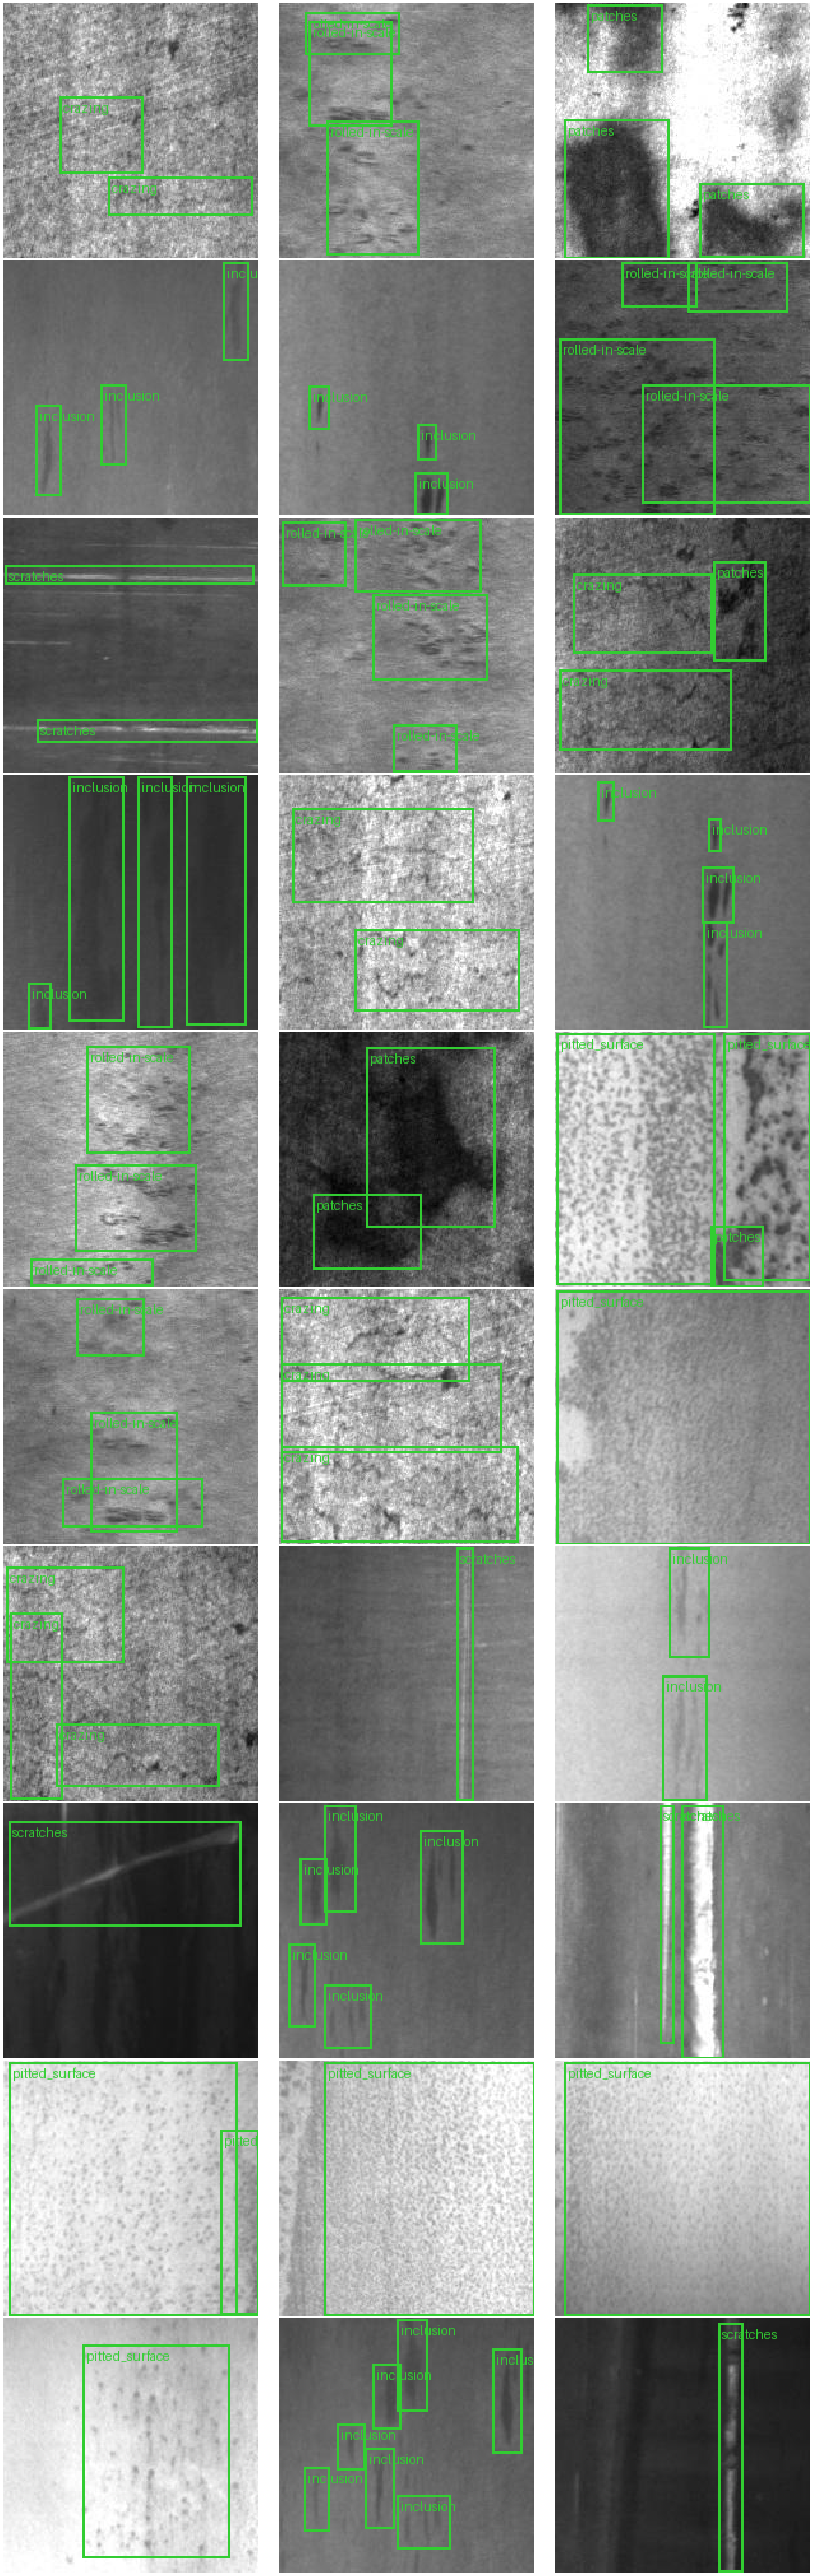

In [9]:
class_names = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in-scale', 'scratches']
indices = random.sample(range(len(full_train_dataset)), k=30)

fig, axes = plt.subplots(10, 3, figsize=(25, 75))
axes = axes.flatten()

for i, idx in enumerate(indices):
    img, target = full_train_dataset[idx]
    img_uint8 = (img * 255).to(torch.uint8)

    boxes = target['boxes']
    labels = target['labels']

    if len(labels) > 0:
        label_names = [class_names[lb.item() - 1] for lb in labels]
    else:
        label_names = []

    img_with_boxes = draw_bounding_boxes(
        image=img_uint8,
        boxes=boxes,
        labels=label_names,
        colors='limegreen',
        width=2,
        font_size=12
    )

    axes[i].imshow(img_with_boxes.permute(1, 2, 0))
    axes[i].axis('off')

plt.tight_layout(pad=0.5)
plt.show()

# Создание модели

## Деформируемые свертки

Стандартная свертка использует фиксированный размер ядра, что ограничивает возможность сети адаптироваться под различные формы объектов. Решением этой проблемы является деформируемая свертка, в которую добавляются смещения.

In [10]:
class DeformConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1,
                 padding=1, dilation=1, groups=1):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = groups

        self.conv_offset = nn.Conv2d(
            in_channels,
            2 * kernel_size * kernel_size,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            bias=True
        )

        self.weight = nn.Parameter(torch.Tensor(
            out_channels, in_channels, kernel_size, kernel_size
        ))
        self.bias = nn.Parameter(torch.Tensor(out_channels))

        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        nn.init.zeros_(self.bias)
        nn.init.zeros_(self.conv_offset.weight)
        nn.init.zeros_(self.conv_offset.bias)

    def forward(self, x):
        offset = self.conv_offset(x)
        return deform_conv2d(
            x,
            offset,
            self.weight,
            self.bias,
            stride=self.stride,
            padding=self.padding,
            dilation=self.dilation
        )

## Гибридный механизм внимания



Гибридный механизм внимания Гибридный механизм внимания состоит из двух частей: Channel Attention Module (CAM) и Spatial Attention Module (SAM). CAM позволяет определить, какие признаки важны для текущего изображения, а какие - нет. SAM позволяет определить, какие регионы изображения наиболее важны.

In [11]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return x * self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        concat = torch.cat([avg_out, max_out], dim=1)
        attention_map = self.sigmoid(self.conv1(concat))
        return x * attention_map

class HybridAttention(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.cam = ChannelAttention(in_ch)
        self.sam = SpatialAttention()

    def forward(self, x):
        x = self.cam(x)
        x = self.sam(x)
        return x

## Создание нового бэкбона с деформируемыми свертками и гибридным механизмом внимания

In [12]:
class BackboneWithDeformableConvAndAttention(nn.Module):
    def __init__(self, original_backbone):
        super().__init__()
        self.original_backbone = original_backbone

        self._replace_conv_with_deformable(self.original_backbone.body.layer2)
        self._replace_conv_with_deformable(self.original_backbone.body.layer3)
        self._replace_conv_with_deformable(self.original_backbone.body.layer4)

        self.attention = HybridAttention(256)

    def _replace_conv_with_deformable(self, module):
        for name, child in module.named_children():
            if isinstance(child, nn.Conv2d) and child.kernel_size == (3, 3):
                deform_conv = DeformConv2d(
                    child.in_channels,
                    child.out_channels,
                    kernel_size=child.kernel_size[0],
                    stride=child.stride,
                    padding=child.padding,
                    dilation=child.dilation
                )
                deform_conv.weight.data.copy_(child.weight.data)
                if child.bias is not None:
                    deform_conv.bias.data.copy_(child.bias.data)
                setattr(module, name, deform_conv)
            else:
                self._replace_conv_with_deformable(child)

    def forward(self, x):
        features = self.original_backbone(x)
        for key in ['0', '1', '2', '3']:
            if key in features:
                features[key] = self.attention(features[key])

        return features

# Реализация Soft-NMS

Стандартный NMS удаляет перекрывающиеся bounding boxes, что может привести к пропуску объектов. Soft-NMS позволяет постепенно снижать достоверность bounding boxes в зависимости от степени перекрытия.

In [13]:
def soft_nms(boxes, scores, sigma=0.05, thresh=0.05):
    if boxes.numel() == 0 or scores.numel() == 0:
        return []

    boxes = boxes.cpu().float()
    scores = scores.cpu().float()

    if boxes.dim() == 2 and boxes.shape[0] == 4 and boxes.shape[1] != 4:
        boxes = boxes.t()

    if boxes.dim() == 1:
        boxes = boxes.unsqueeze(0)

    if boxes.dim() == 3:
        boxes = boxes[:, 0, :]

    if boxes.shape[1] != 4:
        raise ValueError(f"Expected boxes shape [N, 4], got {boxes.shape}")

    x1 = boxes[:, 0].clone()
    y1 = boxes[:, 1].clone()
    x2 = boxes[:, 2].clone()
    y2 = boxes[:, 3].clone()

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    scores = scores.clone()
    order = torch.argsort(scores, descending=True)
    keep = []

    while order.numel() > 0:
        i = order[0]
        keep.append(i.item())

        if order.numel() == 1:
            break

        remaining = order[1:]
        xx1 = torch.max(x1[i], x1[remaining])
        yy1 = torch.max(y1[i], y1[remaining])
        xx2 = torch.min(x2[i], x2[remaining])
        yy2 = torch.min(y2[i], y2[remaining])

        w = torch.clamp(xx2 - xx1 + 1, min=0.0)
        h = torch.clamp(yy2 - yy1 + 1, min=0.0)
        inter = w * h
        iou = inter / (areas[i] + areas[remaining] - inter + 1e-6)

        weight = torch.exp(-iou * iou / sigma)
        scores[remaining] = scores[remaining] * weight

        idxs = torch.where(scores[remaining] >= thresh)[0]
        order = remaining[idxs]

    return keep

In [14]:
def custom_postprocess_detections(self, class_logits, box_regression, proposals, image_shapes,
                                 soft_nms_sigma=0.05, soft_nms_thresh=0.05):
    device = class_logits.device
    num_classes = class_logits.shape[-1]
    boxes_per_image = [len(boxes_in_image) for boxes_in_image in proposals]
    pred_boxes = self.box_coder.decode(box_regression, proposals)
    pred_scores = F.softmax(class_logits, -1)

    pred_boxes_list = pred_boxes.split(boxes_per_image, 0)
    pred_scores_list = pred_scores.split(boxes_per_image, 0)

    all_boxes = []
    all_scores = []
    all_labels = []

    for boxes, scores, image_shape in zip(pred_boxes_list, pred_scores_list, image_shapes):
        boxes = boxes.clamp(min=0, max=max(image_shape))
        image_boxes = []
        image_scores = []
        image_labels = []

        for label in range(1, num_classes):
            score = scores[:, label]
            mask = score > self.score_thresh
            box = boxes[mask, label]
            score = score[mask]

            if len(box) > 0:
                keep_indices = soft_nms(box.clone(), score.clone(), sigma=soft_nms_sigma, thresh=soft_nms_thresh)

                if len(keep_indices) > 0:
                    keep_tensor = torch.tensor(keep_indices, device=device, dtype=torch.long)
                    image_boxes.append(box[keep_tensor])
                    image_scores.append(score[keep_tensor])
                    image_labels.extend([label] * len(keep_indices))

        if image_boxes:
            image_boxes = torch.cat(image_boxes, dim=0)
            image_scores = torch.cat(image_scores, dim=0)
        else:
            image_boxes = torch.empty((0, 4), device=device)
            image_scores = torch.empty(0, device=device)

        all_boxes.append(image_boxes)
        all_scores.append(image_scores)
        all_labels.append(torch.tensor(image_labels, device=device))

    return all_boxes, all_scores, all_labels

## Сборка улучшенной модели

In [15]:
# Базовая модель
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(
    weights=weights,
    trainable_backbone_layers=5,
    box_detections_per_img=100,
)
# Замена головы классификации
num_classes = 7
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Замена бэкбона с деформируемыми свёртками + механизмом внимания
original_backbone = model.backbone
model.backbone = BackboneWithDeformableConvAndAttention(original_backbone)

# Замена NMS на Soft-NMS
model.roi_heads.postprocess_detections = types.MethodType(custom_postprocess_detections, model.roi_heads)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth


100%|██████████| 167M/167M [00:00<00:00, 186MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithDeformableConvAndAttention(
    (original_backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): 

In [16]:
test_img = torch.randn(1, 3, 800, 800).to(device)
with torch.no_grad():
    out = model.backbone(test_img)
print("Ключи после исправления:", list(out.keys()))
print("Размеры:", {k: v.shape for k, v in out.items()})

Ключи после исправления: ['0', '1', '2', '3', 'pool']
Размеры: {'0': torch.Size([1, 256, 200, 200]), '1': torch.Size([1, 256, 100, 100]), '2': torch.Size([1, 256, 50, 50]), '3': torch.Size([1, 256, 25, 25]), 'pool': torch.Size([1, 256, 13, 13])}


# Обучение модели

In [17]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.0001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.9)


In [19]:
num_epochs = 50 #поставить необходимое количество

for epoch in range(num_epochs):
    print(f"\n Epoch {epoch+1}/{num_epochs}")

    model.train()
    total_loss = 0

    progress_bar = tqdm(full_train_dataloader, desc="Training", leave=False)
    for batch_idx, (images, targets) in enumerate(progress_bar):

        images = [img.to(device, non_blocking=True) for img in images]
        targets = [{k: v.to(device, non_blocking=True) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()
        progress_bar.set_postfix({
            'batch_loss': f"{losses.item():.4f}",
            'avg_loss': f"{total_loss / (batch_idx + 1):.4f}"
        })

    avg_train_loss = total_loss / len(full_train_dataloader)

    lr_scheduler.step()

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1} finished | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"LR: {current_lr:.6f}")


 Epoch 1/50


KeyboardInterrupt: 

## Полный чекпонит после обучения

Сохраняем полный чекпоинт для возможности продолжения обучения модели начиная с последней эпохи

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': lr_scheduler.state_dict(),
}, f"faster_rcnn_neu_det_v5_Modification_1_lr_0.0001_STPLR_4_0.9_EP_{epoch}.pth") #сохранение локально, поменять путь при сохранении на Google Disk
print(f"Файл сохранен как: faster_rcnn_neu_det_v5_Modification_1_lr_0.0001_STPLR_4_0.9_EP_{epoch}.pth")

Файл сохранен как: faster_rcnn_neu_det_v5_Modification_1_lr_0.0001_STPLR_4_0.9_EP_0.pth


# Загрузка чекпоинта и тестирование модели

Создаем новый экземпляр модели

In [18]:
model_test = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(
    weights=None,
    trainable_backbone_layers=5,
    box_detections_per_img=100
)

num_classes = 7
in_features = model_test.roi_heads.box_predictor.cls_score.in_features
model_test.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

original_backbone = model_test.backbone
model_test.backbone = BackboneWithDeformableConvAndAttention(original_backbone)

model_test.roi_heads.postprocess_detections = types.MethodType(custom_postprocess_detections, model_test.roi_heads)

/usr/local/lib/python3.12/dist-packages/torchvision/models/detection/backbone_utils.py:162: UserWarning: Changing trainable_backbone_layers has no effect if neither pretrained nor pretrained_backbone have been set to True, falling back to trainable_backbone_layers=5 so that all layers are trainable
  warnings.warn(


In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_test.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithDeformableConvAndAttention(
    (original_backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): 

Загружаем лучший чекпоинт для тестирования

In [20]:
file_id = "1Tt8VQ2E5IJDkeK_D12_E8fbXzTO5RpvH"
output_filename = "faster_rcnn_neu_det_v5_Modification_1_lr_0.0001_STPLR_4_0.9_EP_90.pth"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_filename, quiet=False, fuzzy=True)

checkpoint_path = output_filename
#checkpoint_path = "/content/drive/MyDrive/Datasets/faster_rcnn_neu_det_v5_Modification_1_lr_0.0001_STPLR_4_0.9_EP_90.pth" #При скачивании со своего Google Disk
#checkpoint_path = "faster_rcnn_neu_det_v5_Modification_1_lr_0.0001_STPLR_4_0.9_EP_90.pth" #При локальном расположении файла чекпоинта
print(f"Файл скачан: {checkpoint_path}")

Downloading...
From (original): https://drive.google.com/uc?id=1Tt8VQ2E5IJDkeK_D12_E8fbXzTO5RpvH
From (redirected): https://drive.google.com/uc?id=1Tt8VQ2E5IJDkeK_D12_E8fbXzTO5RpvH&confirm=t&uuid=f4860648-9e06-4ffd-bbe5-25f975aad70c
To: /content/faster_rcnn_neu_det_v5_Modification_1_lr_0.0001_STPLR_4_0.9_EP_90.pth
100%|██████████| 352M/352M [00:06<00:00, 54.5MB/s]

Файл скачан: faster_rcnn_neu_det_v5_Modification_1_lr_0.0001_STPLR_4_0.9_EP_90.pth


In [21]:
checkpoint = torch.load(checkpoint_path, map_location=device)

In [22]:
model_test.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

Тестирование модели при пороге IoU = 0.5

In [23]:
class_names = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in-scale', 'scratches']

metric = MeanAveragePrecision(
    box_format='xyxy',
    iou_thresholds=[0.5],
    class_metrics=True,
    compute_on_cpu=True,
    extended_summary=True
)

model_test.eval()

for images, targets in tqdm(test_loader, desc="Testing"):
    images = [img.to(device) for img in images]

    with torch.no_grad():
        outputs = model_test(images)

    preds = []
    target_list = []
    for i in range(len(outputs)):
        pred = {
            'boxes': outputs[i]['boxes'].cpu(),
            'scores': outputs[i]['scores'].cpu(),
            'labels': outputs[i]['labels'].cpu()
        }
        target = {
            'boxes': targets[i]['boxes'].cpu(),
            'labels': targets[i]['labels'].cpu()
        }
        preds.append(pred)
        target_list.append(target)

    metric.update(preds, target_list)

results = metric.compute()

print("Результат оценки:")
print(" ")
print(f"mAP@0.5:       {results['map_50']:.4f}")

prec = results['precision']
rec = results['recall']

if prec.numel() > 0 and not torch.isnan(prec).all():
    avg_prec = prec[prec >= 0].mean().item()
else:
    avg_prec = 0.0

if rec.numel() > 0 and not torch.isnan(rec).all():
    avg_rec = rec[rec >= 0].mean().item()
else:
    avg_rec = 0.0

avg_f1 = 2 * (avg_prec * avg_rec) / (avg_prec + avg_rec)

print(f"Precision:     {avg_prec:.4f}")
print(f"Recall:        {avg_rec:.4f}")
print(f"F1:            {avg_f1:.4f}")

print(" ")
print("Метрики по классам (AP@0.5)")
print(" ")

map_per_class = results['map_per_class']
for i, class_name in enumerate(class_names):
    ap = map_per_class[i].item()
    if not torch.isnan(torch.tensor(ap)):
        print(f"{class_name:<18}: {ap:.4f}")
    else:
        print(f"{class_name:<18}: N/A")

Testing: 100%|██████████| 180/180 [00:24<00:00,  7.28it/s]


Результат оценки:
 
mAP@0.5:       0.7231
Precision:     0.5718
Recall:        0.6830
F1:            0.6225
 
Метрики по классам (AP@0.5)
 
crazing           : 0.2745
inclusion         : 0.8179
patches           : 0.8767
pitted_surface    : 0.8069
rolled-in-scale   : 0.5736
scratches         : 0.9892


Тестирование модели при порогах IoU [0.5-0.95]

In [24]:
from torchmetrics.detection import MeanAveragePrecision
import torch
from pprint import pprint
from tqdm import tqdm

class_names = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in-scale', 'scratches']

map_metric = MeanAveragePrecision(
    box_format='xyxy',
    class_metrics=True,
    compute_on_cpu=True,
    extended_summary=True
)

model_test.eval()

for images, targets in tqdm(test_loader, desc="Testing"):
    images = [img.to(device) for img in images]

    with torch.no_grad():
        outputs = model_test(images)

    preds = []
    target_list = []
    for i in range(len(outputs)):
        pred = {
            'boxes': outputs[i]['boxes'].cpu(),
            'scores': outputs[i]['scores'].cpu(),
            'labels': outputs[i]['labels'].cpu()
        }
        target = {
            'boxes': targets[i]['boxes'].cpu(),
            'labels': targets[i]['labels'].cpu()
        }
        preds.append(pred)
        target_list.append(target)

    map_metric.update(preds, target_list)

results = map_metric.compute()

print("Результат оценки:")
print(" ")
#print(f"mAP@0.5:       {results['map_50']:.4f}")
print(f"mAP@0.5-0.95:  {results['map']:.4f}")


prec = results['precision']
rec = results['recall']

if prec.numel() > 0 and not torch.isnan(prec).all():
    avg_prec = prec[prec >= 0].mean().item()
else:
    avg_prec = 0.0

if rec.numel() > 0 and not torch.isnan(rec).all():
    avg_rec = rec[rec >= 0].mean().item()
else:
    avg_rec = 0.0

avg_f1 = 2 * (avg_prec * avg_rec) / (avg_prec + avg_rec)

print(f"Precision:     {avg_prec:.4f}")
print(f"Recall:        {avg_rec:.4f}")
print(f"F1:            {avg_f1:.4f}")

print(" ")
print("Метрики по классам (AP@0.5-0.95)")
print(" ")

map_per_class = results['map_per_class']
for i, class_name in enumerate(class_names):
    ap = map_per_class[i].item()
    if not torch.isnan(torch.tensor(ap)):
        print(f"{class_name:<18}: {ap:.4f}")
    else:
        print(f"{class_name:<18}: N/A")

Testing: 100%|██████████| 180/180 [00:25<00:00,  6.93it/s]


Результат оценки:
 
mAP@0.5-0.95:  0.3839
Precision:     0.3092
Recall:        0.3935
F1:            0.3463
 
Метрики по классам (AP@0.5-0.95)
 
crazing           : 0.0676
inclusion         : 0.4158
patches           : 0.5834
pitted_surface    : 0.5068
rolled-in-scale   : 0.1926
scratches         : 0.5373


## Тестирование модели без Soft-NMS

In [25]:
model_test = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(
    weights=None,
    trainable_backbone_layers=5,
    box_detections_per_img=100
)

num_classes = 7
in_features = model_test.roi_heads.box_predictor.cls_score.in_features
model_test.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

original_backbone = model_test.backbone
model_test.backbone = BackboneWithDeformableConvAndAttention(original_backbone)

# Оставляем обычный NMS
#model_test.roi_heads.postprocess_detections = types.MethodType(custom_postprocess_detections, model_test.roi_heads)

In [26]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_test.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithDeformableConvAndAttention(
    (original_backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): 

In [27]:
model_test.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

Тестирование модели при пороге IoU = 0.5

In [28]:
class_names = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in-scale', 'scratches']

metric = MeanAveragePrecision(
    box_format='xyxy',
    iou_thresholds=[0.5],
    class_metrics=True,
    compute_on_cpu=True,
    extended_summary=True
)

model_test.eval()

for images, targets in tqdm(test_loader, desc="Testing"):
    images = [img.to(device) for img in images]

    with torch.no_grad():
        outputs = model_test(images)

    preds = []
    target_list = []
    for i in range(len(outputs)):
        pred = {
            'boxes': outputs[i]['boxes'].cpu(),
            'scores': outputs[i]['scores'].cpu(),
            'labels': outputs[i]['labels'].cpu()
        }
        target = {
            'boxes': targets[i]['boxes'].cpu(),
            'labels': targets[i]['labels'].cpu()
        }
        preds.append(pred)
        target_list.append(target)

    metric.update(preds, target_list)

results = metric.compute()

print("Результат оценки:")
print(" ")
print(f"mAP@0.5:       {results['map_50']:.4f}")

prec = results['precision']
rec = results['recall']

if prec.numel() > 0 and not torch.isnan(prec).all():
    avg_prec = prec[prec >= 0].mean().item()
else:
    avg_prec = 0.0

if rec.numel() > 0 and not torch.isnan(rec).all():
    avg_rec = rec[rec >= 0].mean().item()
else:
    avg_rec = 0.0

avg_f1 = 2 * (avg_prec * avg_rec) / (avg_prec + avg_rec)

print(f"Precision:     {avg_prec:.4f}")
print(f"Recall:        {avg_rec:.4f}")
print(f"F1:            {avg_f1:.4f}")

print(" ")
print("Метрики по классам (AP@0.5)")
print(" ")

map_per_class = results['map_per_class']
for i, class_name in enumerate(class_names):
    ap = map_per_class[i].item()
    if not torch.isnan(torch.tensor(ap)):
        print(f"{class_name:<18}: {ap:.4f}")
    else:
        print(f"{class_name:<18}: N/A")

Testing: 100%|██████████| 180/180 [00:25<00:00,  7.03it/s]


Результат оценки:
 
mAP@0.5:       0.7401
Precision:     0.5786
Recall:        0.7289
F1:            0.6451
 
Метрики по классам (AP@0.5)
 
crazing           : 0.3238
inclusion         : 0.8219
patches           : 0.8908
pitted_surface    : 0.8305
rolled-in-scale   : 0.5859
scratches         : 0.9880


Тестирование модели при порогах IoU [0.5-0.95]

In [29]:
from torchmetrics.detection import MeanAveragePrecision
import torch
from pprint import pprint
from tqdm import tqdm

class_names = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in-scale', 'scratches']

map_metric = MeanAveragePrecision(
    box_format='xyxy',
    class_metrics=True,
    compute_on_cpu=True,
    extended_summary=True
)

model_test.eval()

for images, targets in tqdm(test_loader, desc="Testing"):
    images = [img.to(device) for img in images]

    with torch.no_grad():
        outputs = model_test(images)

    preds = []
    target_list = []
    for i in range(len(outputs)):
        pred = {
            'boxes': outputs[i]['boxes'].cpu(),
            'scores': outputs[i]['scores'].cpu(),
            'labels': outputs[i]['labels'].cpu()
        }
        target = {
            'boxes': targets[i]['boxes'].cpu(),
            'labels': targets[i]['labels'].cpu()
        }
        preds.append(pred)
        target_list.append(target)

    map_metric.update(preds, target_list)

results = map_metric.compute()

print("Результат оценки:")
print(" ")
#print(f"mAP@0.5:       {results['map_50']:.4f}")
print(f"mAP@0.5-0.95:  {results['map']:.4f}")


prec = results['precision']
rec = results['recall']

if prec.numel() > 0 and not torch.isnan(prec).all():
    avg_prec = prec[prec >= 0].mean().item()
else:
    avg_prec = 0.0

if rec.numel() > 0 and not torch.isnan(rec).all():
    avg_rec = rec[rec >= 0].mean().item()
else:
    avg_rec = 0.0

avg_f1 = 2 * (avg_prec * avg_rec) / (avg_prec + avg_rec)

print(f"Precision:     {avg_prec:.4f}")
print(f"Recall:        {avg_rec:.4f}")
print(f"F1:            {avg_f1:.4f}")

print(" ")
print("Метрики по классам (AP@0.5-0.95)")
print(" ")

map_per_class = results['map_per_class']
for i, class_name in enumerate(class_names):
    ap = map_per_class[i].item()
    if not torch.isnan(torch.tensor(ap)):
        print(f"{class_name:<18}: {ap:.4f}")
    else:
        print(f"{class_name:<18}: N/A")

Testing: 100%|██████████| 180/180 [00:25<00:00,  6.96it/s]


Результат оценки:
 
mAP@0.5-0.95:  0.3941
Precision:     0.3137
Recall:        0.4224
F1:            0.3600
 
Метрики по классам (AP@0.5-0.95)
 
crazing           : 0.0869
inclusion         : 0.4175
patches           : 0.5926
pitted_surface    : 0.5136
rolled-in-scale   : 0.2107
scratches         : 0.5434


## Визуализация предсказаний модели

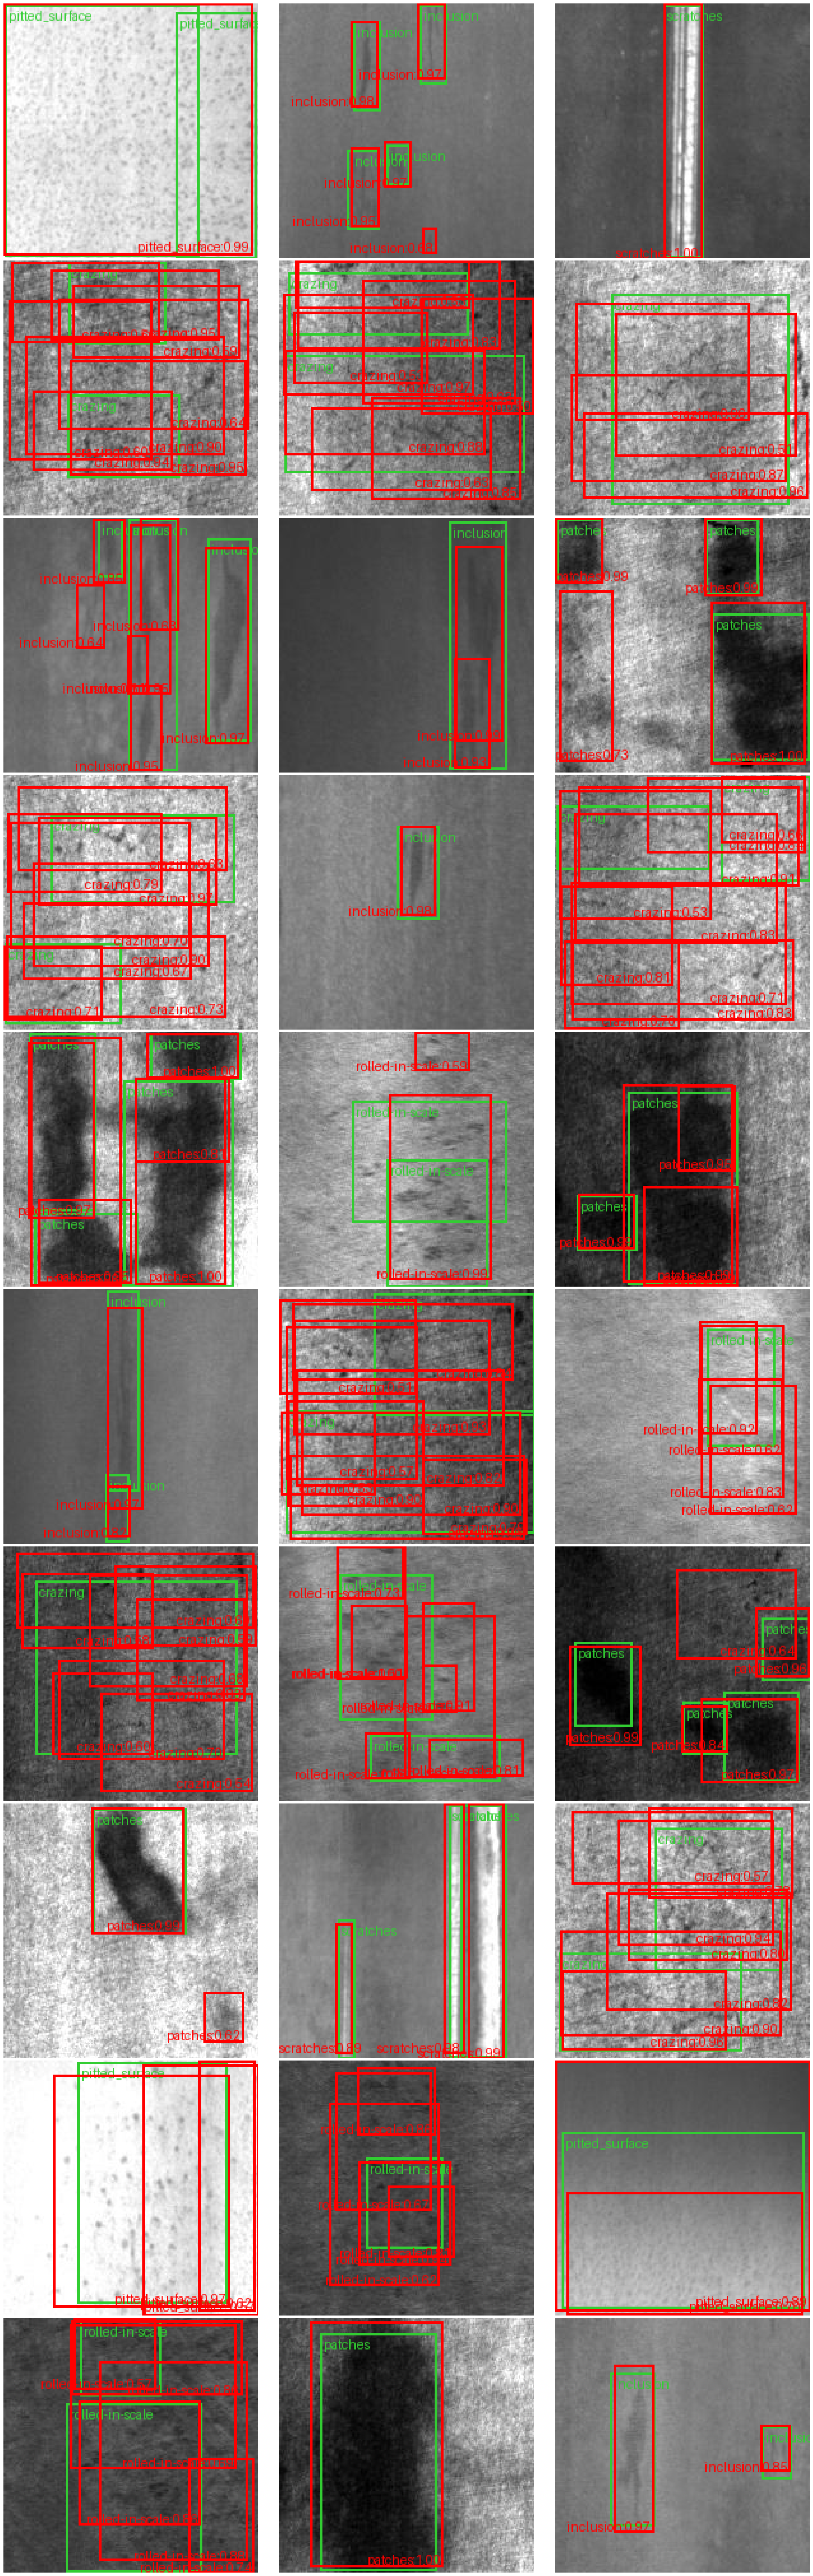

In [30]:
model_test.eval()

class_names = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in-scale', 'scratches']

indices = random.sample(range(len(test_dataset)), k=30)

fig, axes = plt.subplots(10, 3, figsize=(25, 75))
axes = axes.flatten()

with torch.no_grad():
    for i, idx in enumerate(indices):
        img, target = test_dataset[idx]
        img_tensor = img.unsqueeze(0).to(device)

        model_output = model_test(img_tensor)[0]

        gt_boxes = target['boxes']
        gt_labels = target['labels']
        gt_label_names = [class_names[lb.item() - 1] for lb in gt_labels] if len(gt_labels) > 0 else []

        img_uint8 = (img * 255).to(torch.uint8)
        img_with_gt = draw_bounding_boxes(
            image=img_uint8,
            boxes=gt_boxes,
            labels=gt_label_names,
            colors='limegreen',
            width=2,
            font_size=14
        )

        pred_boxes = model_output['boxes']
        pred_scores = model_output['scores']
        pred_labels = model_output['labels']

        keep = pred_scores >= 0.5
        pred_boxes = pred_boxes[keep].cpu()
        pred_labels = pred_labels[keep].cpu()
        pred_scores = pred_scores[keep].cpu()

        img_pil = transforms.ToPILImage()(img_with_gt)
        draw = ImageDraw.Draw(img_pil)

        try:
            font = ImageFont.truetype("DejaVuSans.ttf", 14)
        except:
            font = ImageFont.load_default()

        for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
            x1, y1, x2, y2 = box.tolist()
            class_name = class_names[label.item() - 1]
            text = f"{class_name}:{score:.2f}"

            draw.rectangle([x1, y1, x2, y2], outline='red', width=2)

            bbox = draw.textbbox((0, 0), text, font=font)
            text_width = bbox[2] - bbox[0]
            text_height = bbox[3] - bbox[1]

            text_x = x2 - text_width - 2
            text_y = y2 - text_height - 2

            text_x = max(0, text_x)
            text_y = max(0, text_y)

            draw.text((text_x, text_y), text, fill='red', font=font)

        final_img = transforms.ToTensor()(img_pil)
        axes[i].imshow(final_img.permute(1, 2, 0))
        axes[i].axis('off')

plt.tight_layout(pad=0.5)
plt.show()

# Продолжение обучения модели, используя чекпоинт

In [31]:
params = [p for p in model_test.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.0001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.9)

In [32]:
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
lr_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

In [33]:
start_epoch = checkpoint['epoch']
start_epoch

90

In [ ]:
total_epochs = 100 #поставить необходимое количество

print(f"Загружено состояние после {start_epoch} эпох")
print(f"Продолжаем обучение с эпохи {start_epoch} до {total_epochs}")
print(f"Текущий LR: {optimizer.param_groups[0]['lr']:.8f}")

for epoch in range(start_epoch, total_epochs):
    print(f"\n Epoch {epoch+1}/{total_epochs}")

    model_test.train()
    total_loss = 0

    progress_bar = tqdm(full_train_dataloader, desc="Training", leave=False)
    for batch_idx, (images, targets) in enumerate(progress_bar):
        images = [img.to(device, non_blocking=True) for img in images]
        targets = [{k: v.to(device, non_blocking=True) for k, v in t.items()} for t in targets]

        loss_dict = model_test(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()
        progress_bar.set_postfix({
            'batch_loss': f"{losses.item():.4f}",
            'avg_loss': f"{total_loss / (batch_idx + 1):.4f}"
        })

    avg_train_loss = total_loss / len(full_train_dataloader)

    lr_scheduler.step()

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1} finished | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"LR: {current_lr:.6f}")

In [ ]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model_test.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': lr_scheduler.state_dict(),
}, f"faster_rcnn_neu_det_v5_Modification_1_lr_0.0001_STPLR_4_0.9_EP_{epoch}.pth") #сохранение локально, поменять путь при сохранении на Google Disk
print(f"Файл сохранен как: faster_rcnn_neu_det_v5_Modification_1_lr_0.0001_STPLR_4_0.9_EP_{epoch}.pth")